Test the hypothesis that the early phase of UNet learning learn a linear convolutional structure that denoise the noise to be patch like

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint


saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [3]:
def find_all_ckpt_steps(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if verbose:
        print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
    return sorted(ckpt_steps)

In [4]:
def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

device = "cuda" if torch.cuda.is_available() else "cpu"

### Key Util functions

In [5]:
def fit_linear_conv_denoiser(x_probe, denoised, kernel_size=5, lambda_reg=1e-3, device=None):
    """
    Fits a linear denoiser using closed-form least squares solution.
    
    Args:
        x_probe: Input noisy images tensor of shape (N, C_in, H, W)
        denoised: Target denoised images tensor of shape (N, C_out, H_out, W_out)
        kernel_size: Size of the convolutional kernel (default: 17)
        lambda_reg: Ridge regularization parameter (default: 1e-3)
        device: Device to perform computations on (default: None, will use input device)
        
    Returns:
        conv_model: Fitted nn.Conv2d model
        mse_closedform: MSE of the closed-form solution
        mse_conv: MSE of the conv2d implementation
    """
    if device is None:
        device = x_probe.device
        
    X = x_probe.to(device)
    Y = denoised.to(device)
    P = kernel_size
    C_out = Y.shape[1]
    C_in = X.shape[1]
    
    # X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
    unfold = torch.nn.Unfold(kernel_size=P, padding=P//2)
    X_patches = unfold(X)  
    # → (N, C_in*P*P, H_out*W_out)
    # reshape for regression:
    N, D, K = X_patches.shape       # D = C_in*P*P,  K = H_out*W_out
    X_mat = X_patches.permute(0,2,1).reshape(-1, D)      # (N*K, D)
    Y_mat = Y.permute(0,2,3,1).reshape(-1, C_out)        # (N*K, C_out)

    # Add a column of ones to X_mat for the bias term
    X_mat_bias = torch.cat([X_mat, torch.ones(X_mat.shape[0], 1, device=device)], dim=1)
    
    # Closed‑form least squares (with ridge λ):
    λ = lambda_reg
    D_bias = X_mat_bias.shape[1]  # D + 1 with bias
    eye_bias = torch.eye(D_bias, device=device)
    eye_bias[-1,-1] = 0 # no regularization on the bias term
    A = X_mat_bias.T @ X_mat_bias + λ*eye_bias
    B = X_mat_bias.T @ Y_mat
    W_star_bias = torch.linalg.solve(A, B)   # (D+1, C_out)
    
    # Extract weights and bias
    W_star = W_star_bias[:D, :]
    bias = W_star_bias[D:, :]
    
    # Calculate MSE of closed form solution
    MSE_closedform = ((X_mat_bias @ W_star_bias - Y_mat)**2).mean()
    print(f"MSE of OLS closed form solution: {MSE_closedform.item()}")
    
    # reshape to conv‑kernel:
    W_conv = W_star.T.reshape(C_out, C_in, P, P)
    bias_conv = bias.T.reshape(C_out)

    # Create Conv2d model with the fitted weights
    conv_closedform = nn.Conv2d(
        in_channels=C_in,
        out_channels=C_out,
        kernel_size=P,
        padding=P // 2,   # to match "same" output size
        bias=True        # or True if you also fitted a bias
    )
    
    # Copy in the closed‐form weights
    with torch.no_grad():
        conv_closedform.weight.copy_(W_conv)
        conv_closedform.bias.copy_(bias_conv)

    # Move model to device and evaluate
    conv_closedform = conv_closedform.to(device)
    denoised_conv = conv_closedform(x_probe.to(device))
    MSE_conv = ((denoised_conv - denoised)**2).mean()
    print(f"MSE of conv2d: {MSE_conv.item()}")
    
    return conv_closedform, MSE_closedform, MSE_conv


def eval_linear_conv_denoiser(conv_closedform, x_probe, denoised, device=None):
    if device is None:
        device = x_probe.device
    denoised_conv = conv_closedform(x_probe.to(device))
    MSE_conv = ((denoised_conv - denoised)**2).mean()
    print(f"MSE of conv2d: {MSE_conv.item()}")
    return MSE_conv


# # Example usage:
# P = 13
# conv_closedform, mse_closedform, mse_conv = fit_linear_conv_denoiser(
#     x_probe=x_probe.to(device), 
#     denoised=denoised.to(device), 
#     kernel_size=P, 
#     lambda_reg=1e-3, 
#     device=device
# )
# eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
#                           test_denoised.cuda());

## CNN 32

In [8]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 32,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


In [9]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")

ref_img_idx = 188
noise_seed = 15
ref_x_raw = data_Xtsr[ref_img_idx] # 77 is a nice example
ref_x = (ref_x_raw - 0.5) / 0.5
ckpt_step_list = find_all_ckpt_steps(ckptdir)
step2plot = ckpt_step_list[::10]
# denoises_col_fewer = compute_denoised_images(CNN_precd, ckptdir, step2plot, ref_x, noise_z=None, noise_seed=noise_seed)
# # Call the function with the current parameters
# imgtsr_all, imggrid_all = visualize_denoising_trajectory(denoises_col_fewer, denoiserdir, ref_img_idx, noise_seed, )
# step2plot = ckpt_step_list[::2]
# denoises_col = compute_denoised_images(CNN_precd, ckptdir, step2plot, ref_x, noise_z=None, noise_seed=noise_seed)

Found 171 checkpoints in the directory, largest step is 249999


In [10]:
ckpt_step_list[50]

138

### Demo

In [11]:
step = ckpt_step_list[35]#ckpt_step_list[50]# ckpt_step_list[20]
CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{step:06d}.pth")))
CNN_precd = CNN_precd.to(device).eval()
CNN_precd.requires_grad_(False)
noise_seed = 42
noise_z = torch.randn((30, 3, 32, 32), 
        generator=torch.Generator().manual_seed(noise_seed))
noise_level = 5.0
x_probe = ref_x + noise_level * noise_z
t_sigma = noise_level * torch.ones(noise_z.shape[0], device=device)
denoised = CNN_precd(x_probe.to(device), t_sigma)
denoised.shape

test_noise_z = torch.randn((50,3,32,32), 
        generator=torch.Generator().manual_seed(noise_seed+1))
test_x_probe = ref_x + noise_level * test_noise_z
test_t_sigma = noise_level * torch.ones(1, device=device)
test_denoised = CNN_precd(test_x_probe.to(device), test_t_sigma)
test_denoised.shape

torch.Size([50, 3, 32, 32])

In [13]:
import torch
import torch.nn.functional as F

P = 11

X = x_probe.to(device)
Y = denoised.to(device)
C_out = Y.shape[1]
C_in = X.shape[1]
# X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
unfold = torch.nn.Unfold(kernel_size=P, padding=P//2)
X_patches = unfold(X)  
# → (N, C_in*P*P, H_out*W_out)
# reshape for regression:
N, D, K = X_patches.shape       # D = C_in*P*P,  K = H_out*W_out
X_mat = X_patches.permute(0,2,1).reshape(-1, D)      # (N*K, D)
Y_mat = Y.permute(0,2,3,1).reshape(-1, C_out)        # (N*K, C_out)

# Add a column of ones to X_mat for the bias term
X_mat_bias = torch.cat([X_mat, torch.ones(X_mat.shape[0], 1, device=device)], dim=1)
# Closed‑form least squares (with ridge λ):

λ = 1e-3
D_bias = X_mat_bias.shape[1]  # D + 1 with bias
eye_bias = torch.eye(D_bias, device=device)
eye_bias[-1,-1] = 0 # no regularization on the bias term
A = X_mat_bias.T @ X_mat_bias + λ*eye_bias
B = X_mat_bias.T @ Y_mat
W_star_bias = torch.linalg.solve(A, B)   # (D+1, C_out)
# Extract weights and bias
W_star = W_star_bias[:D, :]
bias = W_star_bias[D:, :]
# print the l2 score of pred vs Y
MSE_closedform = ((X_mat_bias @ W_star_bias - Y_mat)**2).mean()
print(f"MSE of OLS closed form solution: {MSE_closedform.item()}")
# reshape to conv‑kernel:
W_conv = W_star.T.reshape(C_out, C_in, P, P)
bias_conv = bias.T.reshape(C_out)

# 1) Using nn.Conv2d
conv_closedform = nn.Conv2d(
    in_channels=C_in,
    out_channels=C_out,
    kernel_size=P,
    padding=P // 2,   # to match “same” output size
    bias=True        # or True if you also fitted a bias
)
# Copy in the closed‐form weights
with torch.no_grad():
    conv_closedform.weight.copy_(W_conv)
    conv_closedform.bias.copy_(bias_conv)

# use it and print the l2 score of pred vs Y
conv_closedform.to(device)
denoised_conv = conv_closedform(x_probe.cuda())
MSE_conv = ((denoised_conv - denoised)**2).mean()
print(f"MSE of conv2d: {MSE_conv.item()}")

MSE of OLS closed form solution: 0.007932531647384167
MSE of conv2d: 0.007932531647384167


### Visualize 

MSE of conv: 0.008405780419707298


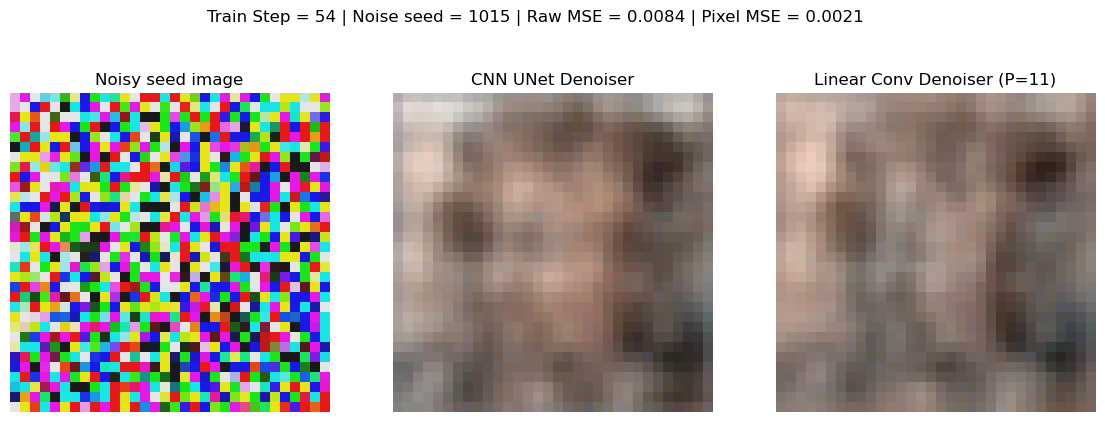

MSE of conv: 0.0071447379887104034


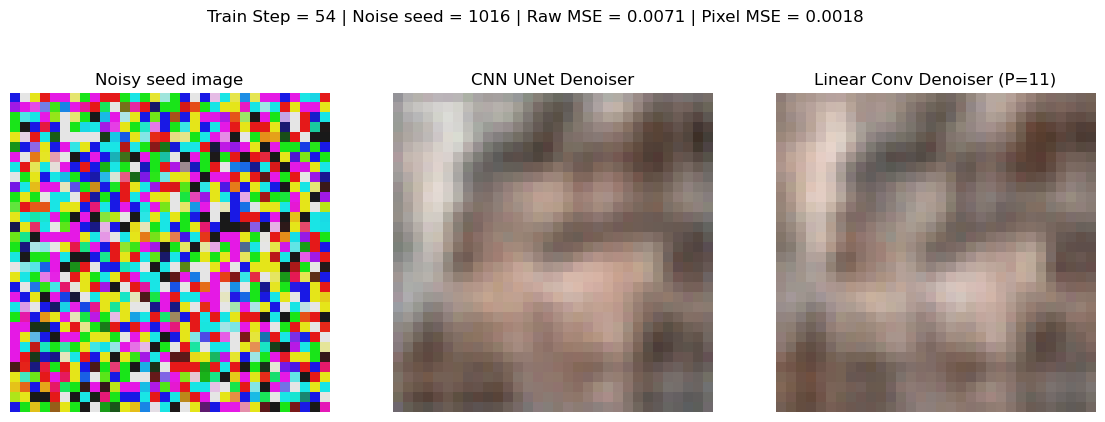

MSE of conv: 0.006998786237090826


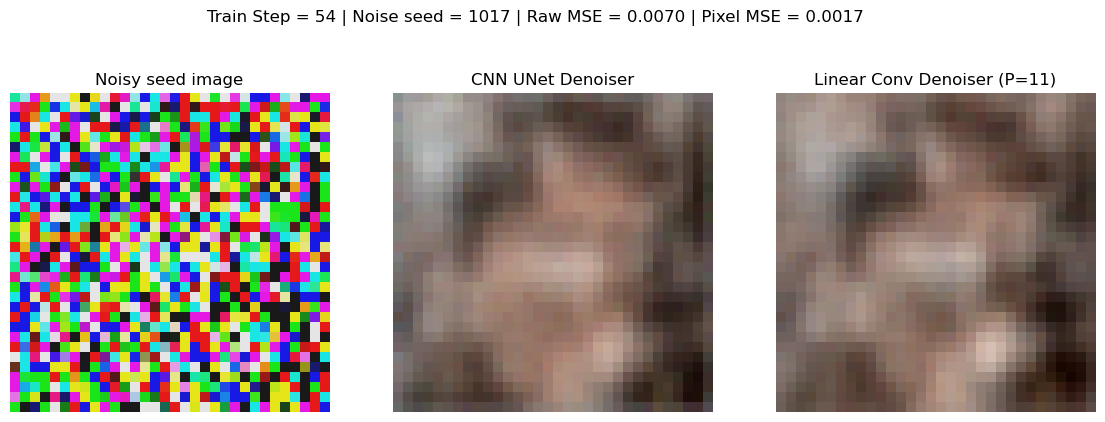

MSE of conv: 0.010150618851184845


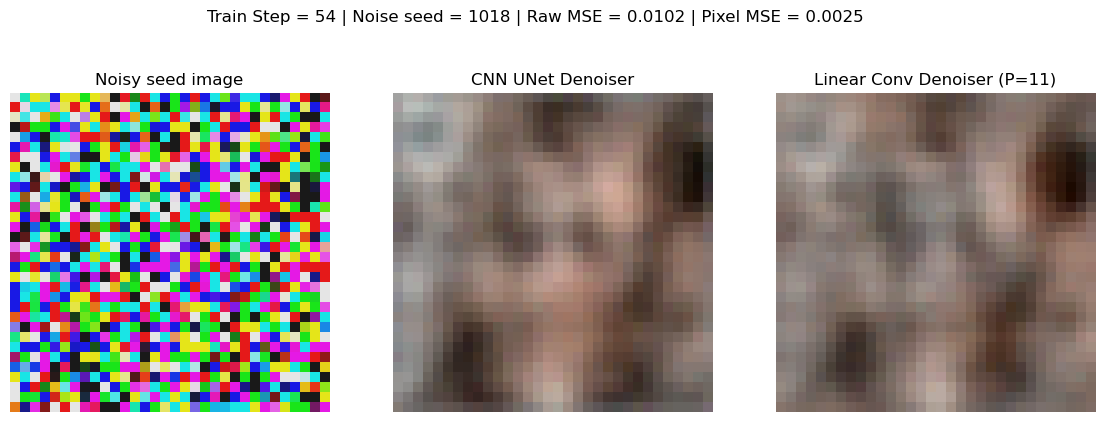

MSE of conv: 0.008271899074316025


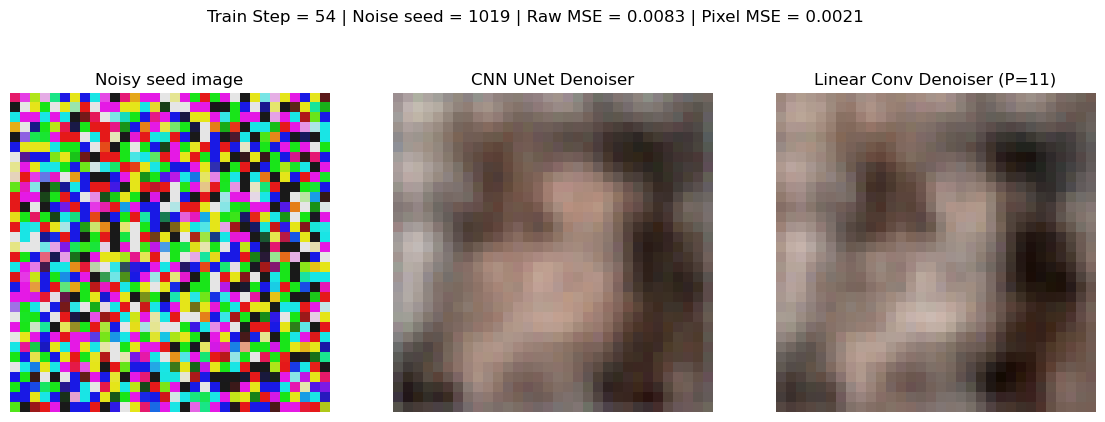

In [14]:
P = 11
# conv_closedform, mse_closedform, mse_conv = fit_linear_denoiser(
#         x_probe, denoised, 
#         kernel_size=P, lambda_reg=1e-3, device=device
# )
conv_closedform = conv_closedform.to(device)
for noise_seed in range(1015, 1020):
    noise_z = torch.randn((1,3,32,32), 
            generator=torch.Generator().manual_seed(noise_seed))
    noise_level = 5.0
    x_probe = ref_x + noise_level * noise_z
    t_sigma = noise_level * torch.ones(1, device=device)
    with torch.no_grad():
        denoised = CNN_precd(x_probe.to(device), t_sigma)
        denoised_conv = conv_closedform(x_probe.cuda())
    # mse 
    MSE_conv = ((denoised_conv - denoised)**2).mean()
    print(f"MSE of conv: {MSE_conv.item()}")
    # plot and compare the two images
    denoiser_img = (denoised.cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) + 1) / 2
    denoiser_img_conv = (denoised_conv.detach().cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) + 1) / 2
    MSE_img = ((denoiser_img - denoiser_img_conv)**2).mean()
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(x_probe.cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) / noise_level / 0.5 + 0.5)
    plt.title(f"Noisy seed image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(denoiser_img)
    plt.title(f"CNN UNet Denoiser")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(denoiser_img_conv)
    plt.title(f"Linear Conv Denoiser (P={P})")
    plt.axis('off')
    plt.suptitle(f"Train Step = {step} | Noise seed = {noise_seed} | Raw MSE = {MSE_conv.item():.4f} | Pixel MSE = {MSE_img.item():.4f}")
    plt.show()

### Key Util function

MSE of OLS closed form solution: 0.003067341633141041
MSE of conv2d: 0.003066794481128454
MSE of conv2d: 0.01739840768277645


In [16]:
step = ckpt_step_list[35]#ckpt_step_list[50]# ckpt_step_list[20]
CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{step:06d}.pth")))
CNN_precd = CNN_precd.to(device).eval()
CNN_precd.requires_grad_(False)
noise_seed = 42
noise_z = torch.randn((30, 3, 32, 32), 
        generator=torch.Generator().manual_seed(noise_seed))
noise_level = 5.0
x_probe = ref_x + noise_level * noise_z
t_sigma = noise_level * torch.ones(noise_z.shape[0], device=device)
denoised = CNN_precd(x_probe.to(device), t_sigma)
denoised.shape

test_noise_z = torch.randn((50,3,32,32), 
        generator=torch.Generator().manual_seed(noise_seed+1))
test_x_probe = ref_x + noise_level * test_noise_z
test_t_sigma = noise_level * torch.ones(1, device=device)
test_denoised = CNN_precd(test_x_probe.to(device), test_t_sigma)
test_denoised.shape

torch.Size([50, 3, 32, 32])

In [17]:
P = 13
conv_closedform, mse_closedform, mse_conv = fit_linear_conv_denoiser(
    x_probe=x_probe.to(device), 
    denoised=denoised.to(device), 
    kernel_size=P, 
    lambda_reg=1e-3, 
    device=device
)
eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
                          test_denoised.cuda());

MSE of OLS closed form solution: 0.007397406734526157
MSE of conv2d: 0.007397406734526157
MSE of conv2d: 0.007414013613015413


### Sweep the patch size

In [18]:
eval_MSE_col = []
for P in [1, 3, 5, 7, 9, 11, 13, 15, 17, 33]:
    print(f"P={P}")
    conv_closedform, mse_closedform, mse_conv = fit_linear_conv_denoiser(
        x_probe, denoised, 
        kernel_size=P, lambda_reg=1e-3, device=device
    )
    print("Eval: ", end="")
    eval_MSE = eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
                          test_denoised.cuda());
    eval_MSE_col.append({"P": P, "MSE": eval_MSE.item(), "mse_closedform": mse_closedform.item(), "mse_conv": mse_conv.item()})

eval_MSE_col = pd.DataFrame(eval_MSE_col)
eval_MSE_col


P=1
MSE of OLS closed form solution: 0.06734731793403625
MSE of conv2d: 0.06734731793403625
Eval: MSE of conv2d: 0.06938252598047256
P=3
MSE of OLS closed form solution: 0.03220609202980995
MSE of conv2d: 0.03220609575510025
Eval: MSE of conv2d: 0.032742731273174286
P=5
MSE of OLS closed form solution: 0.01591438613831997
MSE of conv2d: 0.01591438427567482
Eval: MSE of conv2d: 0.015950728207826614
P=7
MSE of OLS closed form solution: 0.010657742619514465
MSE of conv2d: 0.01065774168819189
Eval: MSE of conv2d: 0.010482119396328926
P=9
MSE of OLS closed form solution: 0.008845088072121143
MSE of conv2d: 0.008845088072121143
Eval: MSE of conv2d: 0.008657806552946568
P=11
MSE of OLS closed form solution: 0.007932531647384167
MSE of conv2d: 0.007932531647384167
Eval: MSE of conv2d: 0.007821700535714626
P=13
MSE of OLS closed form solution: 0.007397406734526157
MSE of conv2d: 0.007397406734526157
Eval: MSE of conv2d: 0.007414013613015413
P=15
MSE of OLS closed form solution: 0.00700586801394

,P,MSE,mse_closedform,mse_conv
0,1,0.069383,0.067347,0.067347
1,3,0.032743,0.032206,0.032206
2,5,0.015951,0.015914,0.015914
3,7,0.010482,0.010658,0.010658
4,9,0.008658,0.008845,0.008845
5,11,0.007822,0.007933,0.007933
6,13,0.007414,0.007397,0.007397
7,15,0.007239,0.007006,0.007006
8,17,0.007129,0.006729,0.006729
9,33,0.006588,0.005343,0.005343


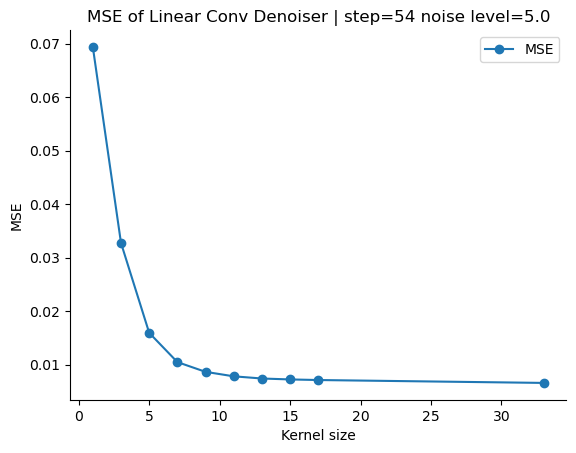

In [19]:
eval_MSE_col.plot(x="P", y="MSE", kind="line", marker="o")
plt.ylabel("MSE")
plt.xlabel("Kernel size")
plt.title(f"MSE of Linear Conv Denoiser | step={step} noise level={noise_level}")
plt.show()

### Mass compute

In [ ]:
eval_MSE_col = []
step = ckpt_step_list[-1]#ckpt_step_list[50]# ckpt_step_list[20]
for step in tqdm(ckpt_step_list[::10]):
    CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{step:06d}.pth")))
    CNN_precd = CNN_precd.to(device).eval()
    CNN_precd.requires_grad_(False)
    noise_seed = 111
    noise_z = torch.randn((50, 3, 32, 32), device=device, 
            generator=torch.Generator(device=device).manual_seed(noise_seed))
    
    test_noise_z = torch.randn((50,3,32,32), device=device, 
            generator=torch.Generator(device=device).manual_seed(noise_seed+1))
    noise_level = 5.0
    for noise_level in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
        x_probe = ref_x.to(device) + noise_level * noise_z
        t_sigma = noise_level * torch.ones(noise_z.shape[0], device=device)
        denoised = CNN_precd(x_probe.to(device), t_sigma)
        test_x_probe = ref_x.to(device) + noise_level * test_noise_z
        test_t_sigma = noise_level * torch.ones(1, device=device)
        test_denoised = CNN_precd(test_x_probe.to(device), test_t_sigma)
        # Example usage:
        for P in [1, 3, 5, 7, 9, 11, 13, 15, 17, 33]:
            print(f"P={P}")
            conv_closedform, mse_closedform, mse_conv = fit_linear_denoiser(
                x_probe, denoised, 
                kernel_size=P, lambda_reg=1e-3, device=device
            )
            # print("Eval: ", end="")
            eval_MSE = eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
                                test_denoised.cuda());
            eval_MSE_col.append({"step": step, "noise_level": noise_level, "noise_seed": noise_seed, 
                                "patch_size": P, "MSE_eval": eval_MSE.item(), "mse_train": mse_closedform.item(), "mse_conv": mse_conv.item()})

eval_MSE_df = pd.DataFrame(eval_MSE_col)
eval_MSE_df

  0%|          | 0/18 [00:00<?, ?it/s]

P=1
MSE of OLS closed form solution: 9.215354174196833e-11
MSE of conv2d: 9.21538401144062e-11
MSE of conv2d: 9.217070856548659e-11
P=3
MSE of OLS closed form solution: 2.0508703069133105e-10
MSE of conv2d: 2.0508701681354324e-10
MSE of conv2d: 2.0531754074681885e-10
P=5
MSE of OLS closed form solution: 6.106256611460026e-10
MSE of conv2d: 6.106256611460026e-10
MSE of conv2d: 6.096910754038731e-10
P=7
MSE of OLS closed form solution: 1.6360275356674947e-09
MSE of conv2d: 1.6360275356674947e-09
MSE of conv2d: 1.6403834957046115e-09
P=9
MSE of OLS closed form solution: 2.165398083064929e-09
MSE of conv2d: 2.165398083064929e-09
MSE of conv2d: 2.1710746533898373e-09
P=11
MSE of OLS closed form solution: 4.132592046346417e-09
MSE of conv2d: 4.132592490435627e-09
MSE of conv2d: 4.1380023851900205e-09
P=13
MSE of OLS closed form solution: 4.05388878021995e-09
MSE of conv2d: 4.05388878021995e-09
MSE of conv2d: 4.073738235632618e-09
P=15
MSE of OLS closed form solution: 7.335277985021094e-08
MS

,step,noise_level,noise_seed,patch_size,MSE_eval,mse_train,mse_conv
0,0,0.001,111,1,9.217071e-11,9.215354e-11,9.215384e-11
1,0,0.001,111,3,2.053175e-10,2.050870e-10,2.050870e-10
2,0,0.001,111,5,6.096911e-10,6.106257e-10,6.106257e-10
3,0,0.001,111,7,1.640383e-09,1.636028e-09,1.636028e-09
4,0,0.001,111,9,2.171075e-09,2.165398e-09,2.165398e-09
...,...,...,...,...,...,...,...
1615,249999,100.000,111,11,2.266911e-02,2.266265e-02,2.266264e-02
1616,249999,100.000,111,13,2.242604e-02,2.211360e-02,2.211360e-02
1617,249999,100.000,111,15,2.226596e-02,2.164475e-02,2.164475e-02
1618,249999,100.000,111,17,2.212928e-02,2.117989e-02,2.117988e-02


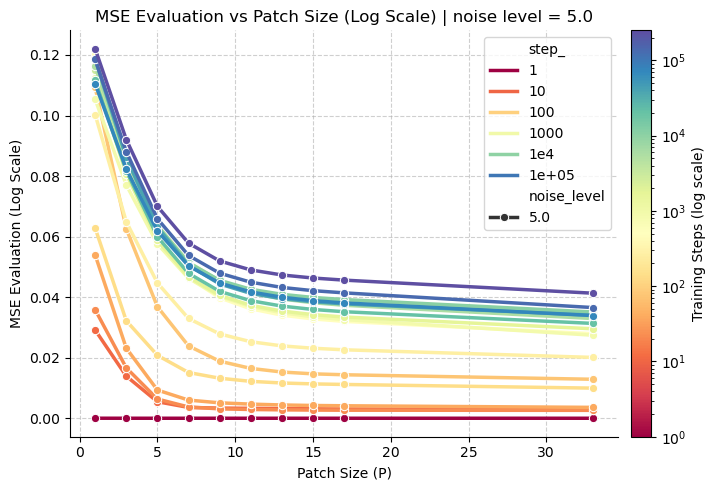

In [ ]:
from matplotlib.colors import LogNorm
eval_MSE_df["step_"] = eval_MSE_df["step"] + 1

norm = LogNorm(
    vmin=eval_MSE_df['step_'].min(),
    vmax=eval_MSE_df['step_'].max()
)
noise_level = 5.0   
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.lineplot(data=eval_MSE_df.query("noise_level == @noise_level"), x="patch_size", y="MSE_eval", hue="step_", hue_norm=norm,
             palette="Spectral", style="noise_level", linewidth=2.5, markers=True, ax=ax)
# plt.yscale('log')
# add a colorbar to show the mapping from log(step) to color
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])  # fake up the array
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Training Steps (log scale)")
plt.title(f"MSE Evaluation vs Patch Size (Log Scale) | noise level = {noise_level}")
plt.xlabel("Patch Size (P)")
plt.ylabel(f"MSE Evaluation (Log Scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
# plt.legend(title="Training Steps", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

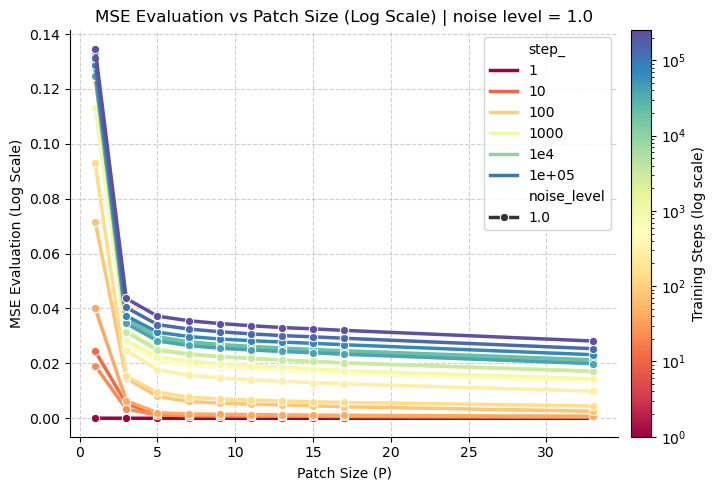

In [ ]:
from matplotlib.colors import LogNorm
eval_MSE_df["step_"] = eval_MSE_df["step"] + 1

norm = LogNorm(
    vmin=eval_MSE_df['step_'].min(),
    vmax=eval_MSE_df['step_'].max()
)
noise_level = 1.0   
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.lineplot(data=eval_MSE_df.query("noise_level == @noise_level"), x="patch_size", y="MSE_eval", hue="step_", hue_norm=norm,
             palette="Spectral", style="noise_level", linewidth=2.5, markers=True, ax=ax)
# plt.yscale('log')
# add a colorbar to show the mapping from log(step) to color
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])  # fake up the array
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Training Steps (log scale)")
plt.title(f"MSE Evaluation vs Patch Size (Log Scale) | noise level = {noise_level}")
plt.xlabel("Patch Size (P)")
plt.ylabel(f"MSE Evaluation (Log Scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
# plt.legend(title="Training Steps", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
figdir = join(savedir, "Fig_linear_conv_denoiser")
os.makedirs(figdir, exist_ok=True)

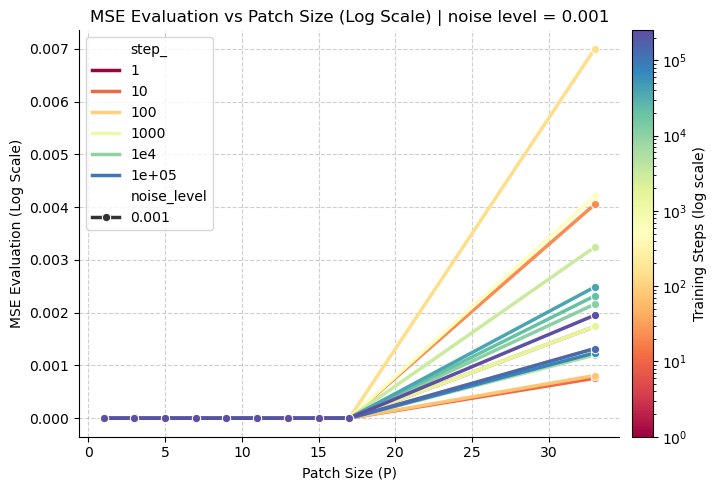

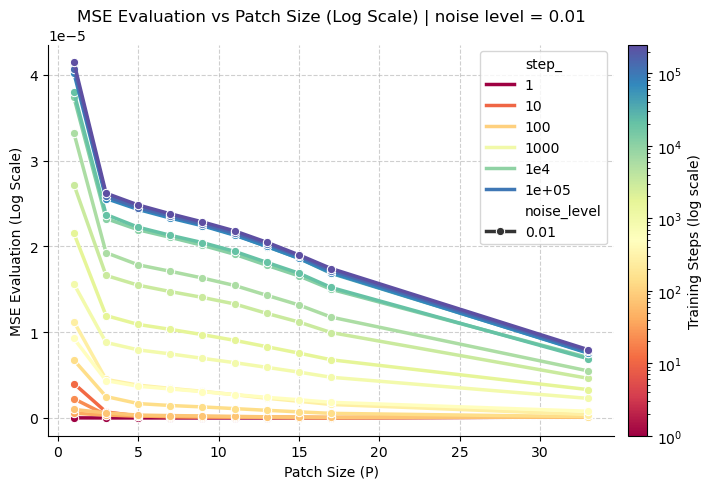

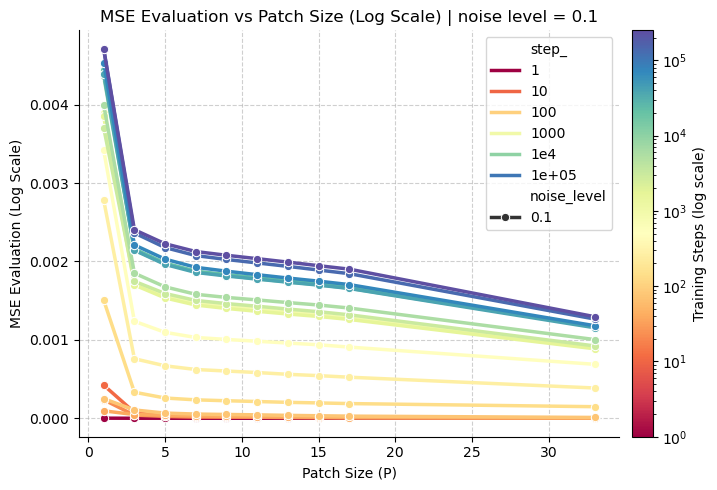

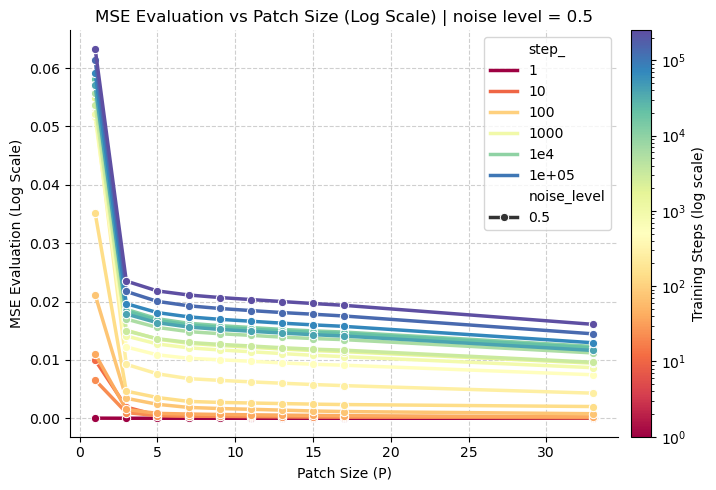

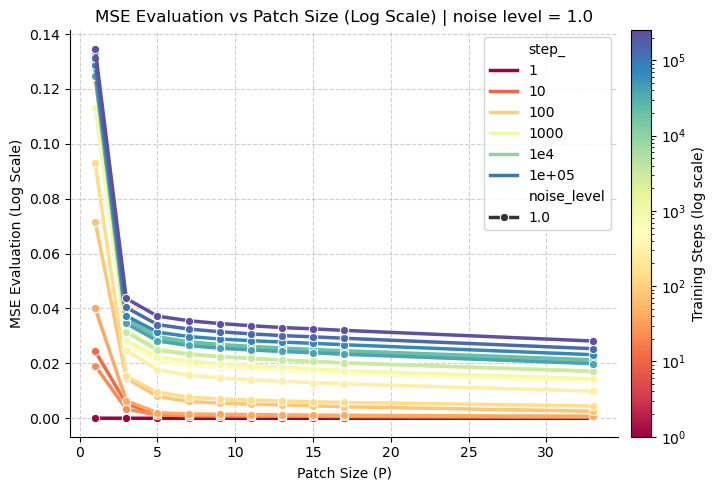

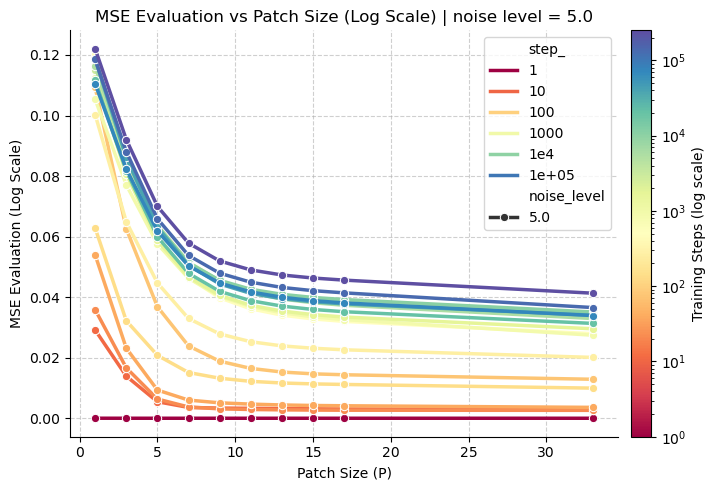

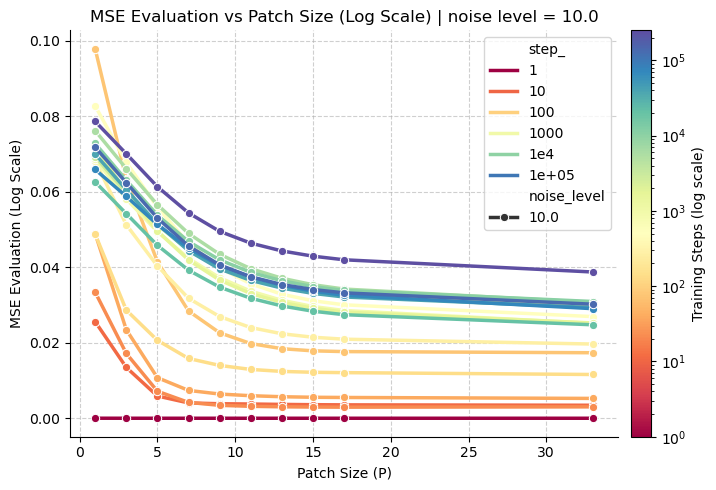

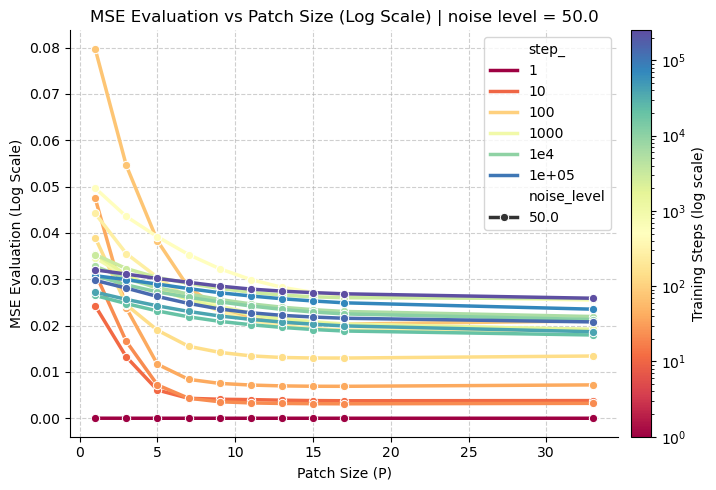

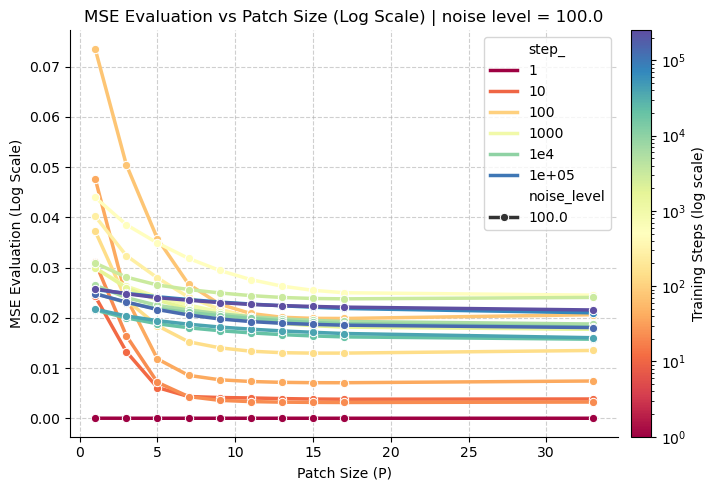

In [ ]:
from matplotlib.colors import LogNorm
eval_MSE_df["step_"] = eval_MSE_df["step"] + 1

norm = LogNorm(
    vmin=eval_MSE_df['step_'].min(),
    vmax=eval_MSE_df['step_'].max()
)
for noise_level in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
    fig, ax = plt.subplots(figsize=(7.5, 5))
    sns.lineplot(data=eval_MSE_df.query("noise_level == @noise_level"), x="patch_size", y="MSE_eval", hue="step_", hue_norm=norm,
                palette="Spectral", style="noise_level", linewidth=2.5, markers=True, ax=ax)
    # plt.yscale('log')
    # add a colorbar to show the mapping from log(step) to color
    sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
    sm.set_array([])  # fake up the array
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Training Steps (log scale)")
    plt.title(f"MSE Evaluation vs Patch Size (Log Scale) | noise level = {noise_level}")
    plt.xlabel("Patch Size (P)")
    plt.ylabel(f"MSE Evaluation (Log Scale)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    # plt.legend(title="Training Steps", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    saveallforms(figdir, f"denoiser_mse_eval_vs_linear_conv_patch_size_noise_level_{noise_level}", figh=fig)
    plt.show()

### Compare Gaussian Covariance predictor and Denoiser and Extract patches from the original image set and compute covariance

In [ ]:
data_Xtsr.shape

torch.Size([70000, 3, 32, 32])

In [ ]:
from einops import rearrange, reduce

In [ ]:
step = ckpt_step_list[45]#ckpt_step_list[50]# ckpt_step_list[20]
CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{step:06d}.pth")))
CNN_precd = CNN_precd.to(device).eval()
CNN_precd.requires_grad_(False)
noise_seed = 42
noise_z = torch.randn((100, 3, 32, 32), 
        generator=torch.Generator().manual_seed(noise_seed))
noise_level = 1.0
x_probe = ref_x + noise_level * noise_z
t_sigma = noise_level * torch.ones(noise_z.shape[0], device=device)
denoised = CNN_precd(x_probe.to(device), t_sigma)
denoised.shape

test_noise_z = torch.randn((100,3,32,32), 
        generator=torch.Generator().manual_seed(noise_seed+1))
test_x_probe = ref_x + noise_level * test_noise_z
test_t_sigma = noise_level * torch.ones(1, device=device)
test_denoised = CNN_precd(test_x_probe.to(device), test_t_sigma)
test_denoised.shape

torch.Size([100, 3, 32, 32])

In [ ]:
P = 15
conv_closedform, mse_closedform, mse_conv = fit_linear_conv_denoiser(
    x_probe=x_probe.to(device), 
    denoised=denoised.to(device), 
    kernel_size=P, 
    lambda_reg=1e-3, 
    device=device
)
eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
                          test_denoised.cuda());

MSE of OLS closed form solution: 0.0062464578077197075
MSE of conv2d: 0.00624645734205842
MSE of conv2d: 0.006205638404935598


In [ ]:
P = 15
X = data_Xtsr[1000:3000].cpu()
X = (X - 0.5) / 0.5
# Y = data_Xtsr[1000:3000].cpu()
C_out = X.shape[1]
C_in = X.shape[1]
# X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
X_patches = unfold(X)
print(X_patches.shape)

torch.Size([2000, 675, 1024])


In [ ]:
n_samples, n_patch_elements, n_positions = X_patches.shape
X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element")
patch_mean = X_patches_flatten.mean(dim=0)
patch_cov = torch.cov(X_patches_flatten.T)  # Transpose to get n_element by n_element covariance matrix

In [ ]:
sigma = noise_level
eye_mat = torch.eye(patch_cov.shape[0])
denoiser_jacobian = patch_cov @ torch.linalg.inv(patch_cov + eye_mat * sigma ** 2)
denoiser_bias = (eye_mat - denoiser_jacobian) @ patch_mean

In [ ]:
W_center = denoiser_jacobian.view(C_in, P, P, C_in, P, P)[:, P//2, P//2, :, :, :]
b_center = denoiser_bias.view(C_in, P, P)[:, P//2, P//2]
print(W_center.shape)
print(b_center.shape)

torch.Size([3, 3, 15, 15])
torch.Size([3])


In [ ]:
denoiser_bias.shape

torch.Size([675])

In [ ]:
b_center

tensor([ 0.0129, -0.0092, -0.0215])

In [ ]:
conv_closedform.weight.data.shape

torch.Size([3, 3, 15, 15])

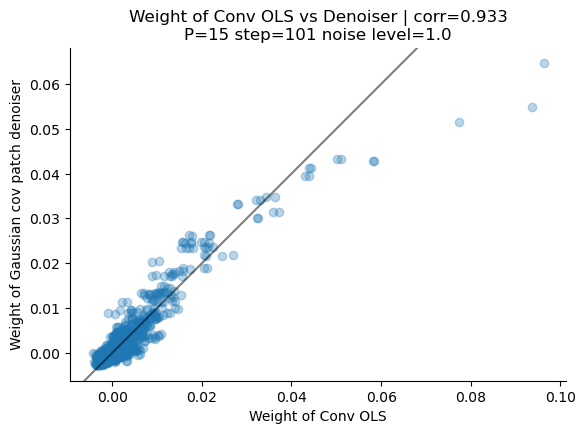

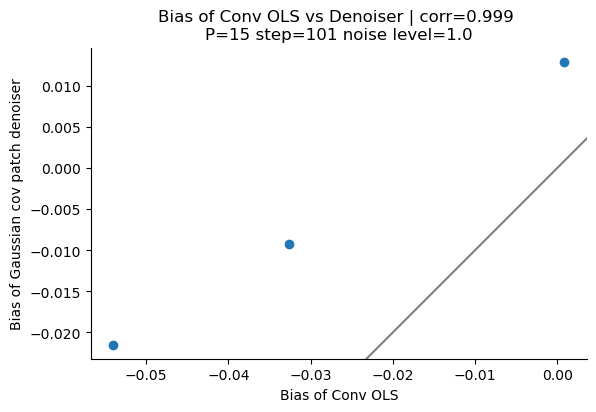

In [ ]:
# correlate the center of the kernel with the weight of the conv model
weight_conv_OLS = conv_closedform.weight.data.detach().cpu()
weight_cov_inv_denoiser = W_center.cpu()
# perform corrcoef
corrcoef = torch.corrcoef(torch.stack([weight_conv_OLS.flatten(), weight_cov_inv_denoiser.flatten()]))
corr = corrcoef[0, 1]
plt.plot(weight_conv_OLS.flatten(), weight_cov_inv_denoiser.flatten(), "o", alpha=0.3)
plt.axline((0, 0), slope=1, color="k", alpha=0.5)
plt.axis("image")
plt.xlabel("Weight of Conv OLS")
plt.ylabel("Weight of Gaussian cov patch denoiser")
plt.title(f"Weight of Conv OLS vs Denoiser | corr={corr:.3f}\nP={P} step={step} noise level={noise_level}")
plt.show()

bias_conv_OLS = conv_closedform.bias.data.detach().cpu()
bias_center = b_center.view(C_in)
corr = torch.corrcoef(torch.stack([bias_conv_OLS, bias_center]))[0, 1]  
plt.plot(bias_conv_OLS, bias_center, "o")
plt.axline((0, 0), slope=1, color="k", alpha=0.5)
plt.axis("image")
plt.xlabel("Bias of Conv OLS")
plt.ylabel("Bias of Gaussian cov patch denoiser")
plt.title(f"Bias of Conv OLS vs Denoiser | corr={corr:.3f} \nP={P} step={step} noise level={noise_level}")
plt.show()

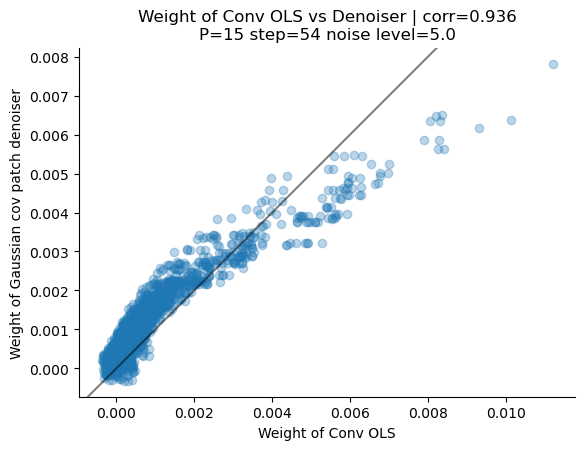

In [ ]:
# correlate the center of the kernel with the weight of the conv model
weight_conv_OLS = conv_closedform.weight.data.detach().cpu()
weight_cov_inv_denoiser = W_center.cpu()
# perform corrcoef
corrcoef = torch.corrcoef(torch.stack([weight_conv_OLS.flatten(), weight_cov_inv_denoiser.flatten()]))
corr = corrcoef[0, 1]
plt.plot(weight_conv_OLS.flatten(), weight_cov_inv_denoiser.flatten(), "o", alpha=0.3)
plt.axline((0, 0), slope=1, color="k", alpha=0.5)
plt.axis("image")
plt.xlabel("Weight of Conv OLS")
plt.ylabel("Weight of Gaussian cov patch denoiser")
plt.title(f"Weight of Conv OLS vs Denoiser | corr={corr:.3f}\nP={P} step={step} noise level={noise_level}")
plt.show()

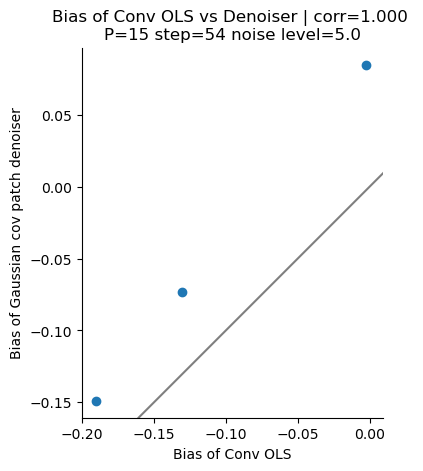

In [ ]:
bias_conv_OLS = conv_closedform.bias.data.detach().cpu()
bias_center = b_center.view(C_in)
corr = torch.corrcoef(torch.stack([bias_conv_OLS, bias_center]))[0, 1]  

plt.plot(bias_conv_OLS, bias_center, "o")
plt.axline((0, 0), slope=1, color="k", alpha=0.5)
plt.axis("image")
plt.xlabel("Bias of Conv OLS")
plt.ylabel("Bias of Gaussian cov patch denoiser")
plt.title(f"Bias of Conv OLS vs Denoiser | corr={corr:.3f} \nP={P} step={step} noise level={noise_level}")
plt.show()


In [ ]:
weight_cov_inv_denoiser

tensor([[[[5.0835e-04, 5.6071e-04, 6.3347e-04,  ..., 6.2813e-04,
           5.5116e-04, 4.9299e-04],
          [5.0377e-04, 5.6495e-04, 6.4922e-04,  ..., 6.4378e-04,
           5.5518e-04, 4.8878e-04],
          [5.0452e-04, 5.7734e-04, 6.7798e-04,  ..., 6.7157e-04,
           5.6664e-04, 4.8922e-04],
          ...,
          [4.3254e-04, 5.0900e-04, 6.1348e-04,  ..., 6.0509e-04,
           4.9746e-04, 4.1760e-04],
          [3.9291e-04, 4.5859e-04, 5.4710e-04,  ..., 5.3786e-04,
           4.4623e-04, 3.7775e-04],
          [3.6561e-04, 4.2302e-04, 4.9999e-04,  ..., 4.9071e-04,
           4.1049e-04, 3.5097e-04]],

         [[3.7998e-04, 4.1186e-04, 4.6339e-04,  ..., 4.6574e-04,
           4.1038e-04, 3.7350e-04],
          [3.7018e-04, 4.0888e-04, 4.6911e-04,  ..., 4.7076e-04,
           4.0664e-04, 3.6369e-04],
          [3.6465e-04, 4.1255e-04, 4.8577e-04,  ..., 4.8643e-04,
           4.0949e-04, 3.5797e-04],
          ...,
          [3.1621e-04, 3.7108e-04, 4.5224e-04,  ..., 4.5078

In [ ]:
weight_conv_OLS

tensor([[[[ 7.5122e-04,  6.5577e-04,  6.6456e-04,  ...,  2.5286e-04,
            1.7064e-04,  1.7281e-04],
          [ 6.6563e-04,  6.1749e-04,  6.1298e-04,  ...,  1.9268e-04,
            6.4824e-05,  5.9261e-05],
          [ 6.7066e-04,  6.2349e-04,  6.4716e-04,  ...,  1.9681e-04,
            6.7197e-05,  3.3037e-05],
          ...,
          [ 3.5197e-04,  4.9920e-04,  6.6851e-04,  ...,  3.1298e-04,
            1.4844e-04,  4.1211e-05],
          [ 3.3977e-04,  4.8486e-04,  6.8754e-04,  ...,  2.3502e-04,
            7.7783e-05, -2.5087e-05],
          [ 3.9608e-04,  5.0561e-04,  6.9775e-04,  ...,  1.8754e-04,
           -2.9785e-05, -1.2755e-04]],

         [[ 4.8002e-04,  4.1147e-04,  3.7443e-04,  ...,  3.1164e-04,
            1.6532e-04,  1.7293e-05],
          [ 4.4182e-04,  3.7747e-04,  3.7746e-04,  ...,  1.8909e-04,
            2.5226e-05, -1.9409e-04],
          [ 3.9964e-04,  3.6929e-04,  4.0228e-04,  ...,  2.8226e-04,
            8.9760e-05, -1.4975e-04],
          ...,
     

## CNN UNet 64

In [6]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


In [7]:
import sys
sys.path.append("/n/home12/binxuwang/Github/edm")
from training.dataset import TensorDataset, ImageFolderDataset
edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
dataset = ImageFolderDataset(edm_ffhq64_path)

In [25]:
ref_img_idx = 188
ref_x_raw = dataset[ref_img_idx][0] # 77 is a nice example
ref_x_raw = torch.from_numpy(ref_x_raw).float() / 255.0
ref_x = (ref_x_raw - 0.5) / 0.5

def fetch_ref_img_tsr(dataset, ref_img_idx=188):
    """
    Fetch a reference image from the dataset and convert it to a tensor.
    """
    if isinstance(ref_img_idx, int):
        ref_x_raw = dataset[ref_img_idx][0] # 77 is a nice example
    # if it's a iterable, then it's a list of images
    elif isinstance(ref_img_idx, (list, tuple, range, np.ndarray)):
        ref_x_raw = ([dataset[i][0] for i in ref_img_idx])
        ref_x_raw = np.stack(ref_x_raw)
    else:
        raise ValueError(f"Invalid reference image index: {ref_img_idx}")
    ref_x_raw = torch.from_numpy(ref_x_raw).float() / 255.0
    ref_x = (ref_x_raw - 0.5) / 0.5
    return ref_x
# denoises_col_fewer = compute_denoised_images(CNN_precd, ckptdir, step2plot, ref_x, noise_z=None, noise_seed=noise_seed)
# # Call the function with the current parameters
# imgtsr_all, imggrid_all = visualize_denoising_trajectory(denoises_col_fewer, denoiserdir, ref_img_idx, noise_seed, )
# step2plot = ckpt_step_list[::2]
# denoises_col = compute_denoised_images(CNN_precd, ckptdir, step2plot, ref_x, noise_z=None, noise_seed=noise_seed)

In [29]:
ckpt_step_list = find_all_ckpt_steps(ckptdir)
step = ckpt_step_list[40]#ckpt_step_list[50]# ckpt_step_list[20]
CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{step:06d}.pth")))
CNN_precd = CNN_precd.to(device).eval()
CNN_precd.requires_grad_(False)
noise_seed = 42
ref_x = fetch_ref_img_tsr(dataset, range(0,50))
noise_z = torch.randn((50, 3, 64, 64), 
        generator=torch.Generator().manual_seed(noise_seed))
noise_level = 5.0
x_probe = ref_x + noise_level * noise_z
t_sigma = noise_level * torch.ones(noise_z.shape[0], device=device)
denoised = CNN_precd(x_probe.to(device), t_sigma)
denoised.shape

test_noise_z = torch.randn((50,3,64,64), 
        generator=torch.Generator().manual_seed(noise_seed+1))
test_x_probe = ref_x + noise_level * test_noise_z
test_t_sigma = noise_level * torch.ones(1, device=device)
test_denoised = CNN_precd(test_x_probe.to(device), test_t_sigma)

ref_x2 = fetch_ref_img_tsr(dataset, range(50,100))
test_noise_z2 = torch.randn((50,3,64,64), 
        generator=torch.Generator().manual_seed(noise_seed+2))
test_x_probe2 = ref_x2 + noise_level * test_noise_z2
test_t_sigma2 = noise_level * torch.ones(1, device=device)
test_denoised2 = CNN_precd(test_x_probe2.to(device), test_t_sigma2)


Found 158 checkpoints in the directory, largest step is 110997


In [30]:
# Example usage:
P = 15
print("Training MSE")
conv_closedform, mse_closedform, mse_conv = fit_linear_conv_denoiser(
    x_probe=x_probe.to(device), 
    denoised=denoised.to(device), 
    kernel_size=P, 
    lambda_reg=1e-3, 
    device=device
)
print("MSE of linear conv denoiser on the same ref image with different noise seeds:")
eval_linear_conv_denoiser(conv_closedform, test_x_probe.cuda(), 
                          test_denoised.cuda());
print("MSE of linear conv denoiser on different ref images with the different noise seed:")
eval_linear_conv_denoiser(conv_closedform, test_x_probe2.cuda(), 
                          test_denoised2.cuda());

Training MSE
MSE of OLS closed form solution: 0.006832243874669075
MSE of conv2d: 0.006832243874669075
MSE of linear conv denoiser on the same ref image with different noise seeds:
MSE of conv2d: 0.007090412080287933
MSE of linear conv denoiser on different ref images with the different noise seed:
MSE of conv2d: 0.00657106377184391


In [35]:
def visualize_denoiser_comparison(ref_xs, CNN_precd, conv_closedform, noise_seeds, noise_level=5.0, P=15, device='cuda'):
    """
    Visualize and compare CNN UNet denoiser with Linear Conv denoiser.
    
    Args:
        ref_x: Reference images
        CNN_precd: CNN UNet denoiser model
        conv_closedform: Linear Conv denoiser model
        noise_seeds: List of noise seeds to use
        noise_level: Noise level to add
        P: Patch size used for linear conv denoiser
        device: Device to run computations on
    """
    conv_closedform = conv_closedform.to(device)
    if ref_xs.ndim == 3:
        ref_xs = ref_xs.unsqueeze(0)
        ref_xs = ref_xs.expand(len(noise_seeds), *ref_xs.shape[1:])
    if ref_xs.ndim == 4 and ref_xs.shape[0] == 1:
        ref_xs = ref_xs.expand(len(noise_seeds), *ref_xs.shape[1:])
    for ref_x, noise_seed in zip(ref_xs, noise_seeds):
        # Generate noisy image
        noise_z = torch.randn((1, 3, 64, 64), 
                generator=torch.Generator().manual_seed(noise_seed))
        x_probe = ref_x + noise_level * noise_z
        t_sigma = noise_level * torch.ones(1, device=device)
        
        # Denoise with both models
        with torch.no_grad():
            denoised = CNN_precd(x_probe.to(device), t_sigma)
            denoised_conv = conv_closedform(x_probe.to(device))
        
        # Calculate MSE between denoised outputs
        MSE_conv = ((denoised_conv - denoised)**2).mean()
        
        # Convert to displayable images
        denoiser_img = (denoised.cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) + 1) / 2
        denoiser_img_conv = (denoised_conv.detach().cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) + 1) / 2
        MSE_img = ((denoiser_img - denoiser_img_conv)**2).mean()
        
        # Plot comparison
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(x_probe.cpu().squeeze().permute(1, 2, 0).clamp(-1, 1) / noise_level / 0.5 + 0.5)
        plt.title(f"Noisy seed image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(denoiser_img)
        plt.title(f"CNN UNet Denoiser")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(denoiser_img_conv)
        plt.title(f"Linear Conv Denoiser (P={P})")
        plt.axis('off')
        plt.suptitle(f"Train Step = {step} | noise level = {noise_level} | Noise seed = {noise_seed} | Raw MSE = {MSE_conv.item():.4f} | Pixel MSE = {MSE_img.item():.4f}")
        plt.show()


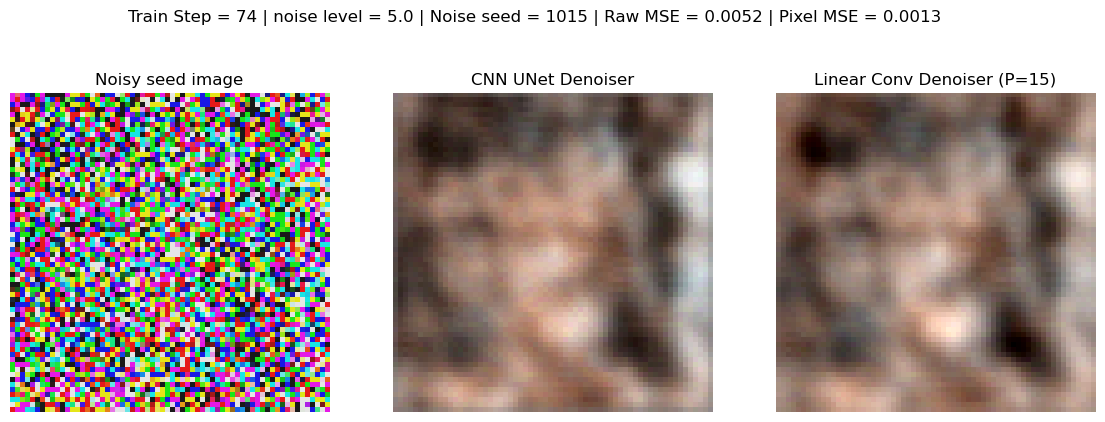

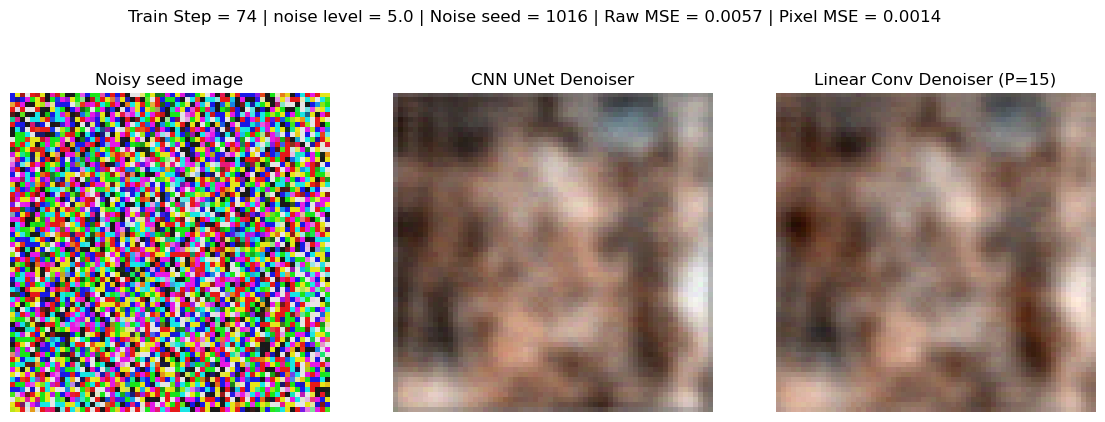

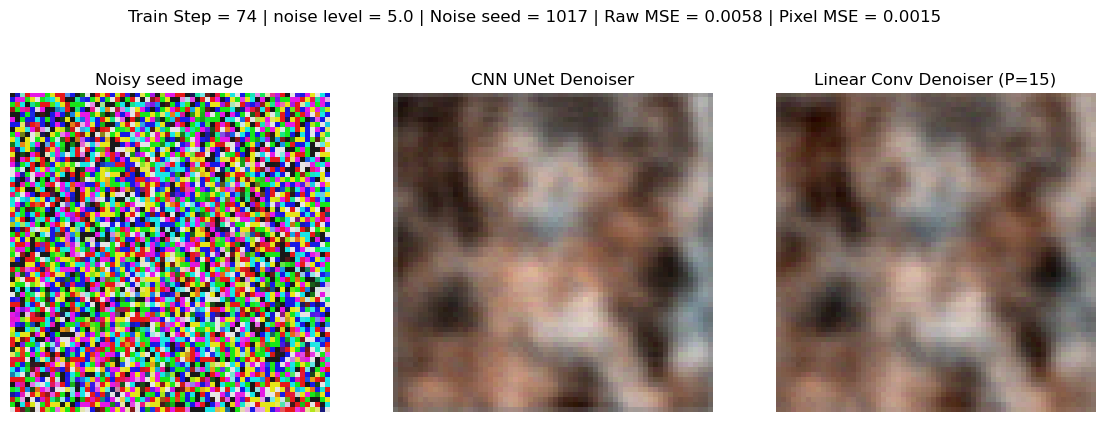

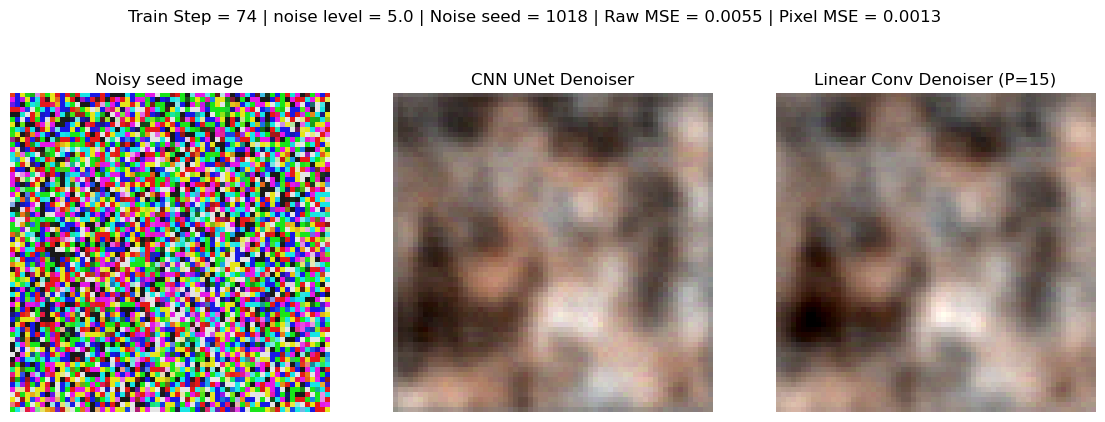

In [38]:
# Call the function with the range of noise seeds
P = 15
ref_xs = fetch_ref_img_tsr(dataset, range(1015, 1020))
ref_xs = fetch_ref_img_tsr(dataset, 5)
noise_seeds = range(1015, 1019)
visualize_denoiser_comparison(
    ref_xs, 
    CNN_precd=CNN_precd, 
    conv_closedform=conv_closedform, 
    noise_seeds=noise_seeds, 
    noise_level=5.0, 
    P=P, 
    device=device
)